In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy

# A/B testing to improve Conversion Rates

You work for Company K. Company K is a video streaming service that is selling subscriptions. After running a few analyses, you suggest to the Product Team that placing more prominent upsells on the landing page may result in higher conversion rates (visitors signing up for the subscription). The Product Team took your suggestion with excitement and the engineering team went ahead and implemented the experiment right away. 

The experiment ran for the month of February 2020. You prepared a few datasets beforehand that will help you in analyzing the success of the A/B test.
The A/B test had two experiment groups, A & B, in which visitors assigned to A were in the control group and visitors assigned to B received the new variant with the new upsells. You suggest to assign approximately 7% of the daily visitors to the experiment, applying a 50/50 split among the two variants.

You have the following datasets:

1. `first_pageviews`: This is a summary of all the unsubscribed users and the timestamp of their first pageview. Users get assigned according to their cookies, which is how we make sure that a user may not be assigned to two different groups when they reach our landing page. Since visitors haven't signed up at this point, they don't have a `user_id`, instead, we assign them a random but unique `anonymous_id`. If visitors get assigned to an experiment, you should see a non-null value in the `exp_id` column. Your experiment has the ids **101** for control and **102** for the variant.
2. `subscribers`: This table shows you which users have subscribed at what point in time. To subscribe, you need to be a registered user, which is how you can uniquely identify each subscriber. Since we only sell yearly subscriptions, users cannot have more than 1 subscription within 365 days. 
3. `users`: This table is useful to link the first pageview of unsubscribed visitors to our subscribers. It keeps track of the `anonymous_id` we assigned to them and maps to the `user_id` we assigned after they sign up

Immediately after the end of the experiment, the Product Manager approaches you overly excited and wants you to analyze the success of the experiment.

You can find the datasets in the `data/2020-03-01` folder.

In [2]:
# load the datasets
first_pageviews = pd.read_csv('./data/2020-03-01/first_pageviews.csv')
subscriptions = pd.read_csv('./data/2020-03-01/subscriptions_mar01.csv')
users = pd.read_csv('./data/2020-03-01/users_mar01.csv')

## Inspect the data

In [3]:
# show the first 5 lines of each dataset
first_pageviews.head()

,date_id,anonymous_id,exp_id
0,2020-01-16,4d005f94-e06f-493c-b569-9efb5ce4d203,NaN
1,2020-01-16,948ad58a-f483-4007-aa56-280aa018427b,NaN
2,2020-01-16,31f4f2e4-4ae6-417b-8a6d-53b98a719145,NaN
3,2020-01-16,24747dc7-355a-44b0-95c6-0caa91cd4ae4,NaN
4,2020-01-16,0162c4f8-7bc2-4432-90b9-bfb61f5e57b3,NaN


In [4]:
subscriptions.head()

,user_id,created_at,client_app
0,b67781da-3a0f-48af-80d8-728d3ec31c66,2020-01-26 09:00:55.628471160,android
1,ce1764ca-91a2-4c2e-95fe-c415c5df7be5,2020-01-30 10:43:16.359589080,ios
2,b24712a4-40b7-4841-a9e9-f566d9ed48a9,2020-02-15 21:19:35.663792880,web
3,d0e4f27e-11ab-470c-85db-4f7389ba63d4,2020-02-13 04:45:52.198410780,ios
4,91b679ad-38cc-4569-b5fc-8a98dc858b8d,2020-02-10 13:24:29.670026400,android


In [5]:
users.head()

,anonymous_id,user_id
0,e575dd8c-f02c-4a1a-8a53-fef7ff2b9f95,b67781da-3a0f-48af-80d8-728d3ec31c66
1,a92532b2-0317-49bb-9f00-3d9b9ae71ea5,ce1764ca-91a2-4c2e-95fe-c415c5df7be5
2,9c39b4d4-d7da-49e2-bcd9-4abee3e211f6,b24712a4-40b7-4841-a9e9-f566d9ed48a9
3,858cc4cc-dcd2-4897-815b-500a2ee8c00e,d0e4f27e-11ab-470c-85db-4f7389ba63d4
4,96a9ad69-568e-40bd-9ff7-3e6b8e0d3f9a,91b679ad-38cc-4569-b5fc-8a98dc858b8d


In [6]:
# check the data types and set them properly for each dataset
print(first_pageviews.dtypes)
print(subscriptions.dtypes)
print(users.dtypes)

# need to change first_pageviews['date_id'] and subscriptions['created_at']
first_pageviews['date_id'] = pd.to_datetime(first_pageviews['date_id'])
subscriptions['created_at'] = pd.to_datetime(subscriptions['created_at'])

date_id          object
anonymous_id     object
exp_id          float64
dtype: object
user_id       object
created_at    object
client_app    object
dtype: object
anonymous_id    object
user_id         object
dtype: object


            anonymous_id
date_id                 
2020-01-16         43732
2020-01-17         46950
2020-01-18         32288
2020-01-19         34464
2020-01-20         52184
2020-01-21         47600
2020-01-22         47255
2020-01-23         48753
2020-01-24         42981
2020-01-25         38896
2020-01-26         35450
2020-01-27         51554
2020-01-28         52380
2020-01-29         42687
2020-01-30         48363
2020-01-31         48357
2020-02-01         41166
2020-02-02         40339
2020-02-03         49347
2020-02-04         46408
2020-02-05         40654
2020-02-06         47631
2020-02-07         45555
2020-02-08         38665
2020-02-09         33122
2020-02-10         52331
2020-02-11         51635
2020-02-12         40572
2020-02-13         46190
2020-02-14         42802
2020-02-15         37441
2020-02-16         38375
2020-02-17         50122
2020-02-18         43863
2020-02-19         47800
2020-02-20         48136
2020-02-21         40440
2020-02-22         33624


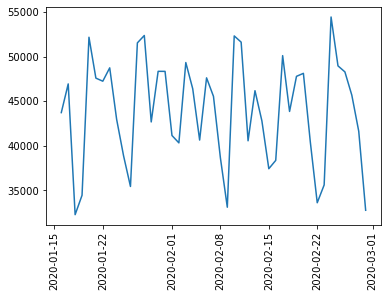

In [35]:
# plot first pageview per day to inspect if you can spot any outliers or anything suspicious
print(pd.pivot_table(data=first_pageviews, index='date_id', values='anonymous_id', aggfunc='count'))

# first make a pivot table, which is essentially what you want to plot. You want the date_id on the X and the anonymous_id on the Y
plt.plot(pd.pivot_table(data=first_pageviews, index='date_id', values='anonymous_id', aggfunc='count'))
plt.xticks(rotation=90)
plt.show()

In [41]:
# check the assignment into the experiment. You should see that 7% of the visitors were 
# assigned to the experiment with a 50/50 split among the two variants

# look to see where exp_id HAS a value
first_pageviews['in_experiment'] = np.where(first_pageviews['exp_id'].isna(),0,1)
first_pageviews[first_pageviews['in_experiment']==1]
first_pageviews['in_experiment'].value_counts()/len(first_pageviews)

# appears to be about 6.8 percent
# BUT we need only the traffic from February, when the experiment runs (if adding this condition, its about a 10% assigment.)

0    0.93143
1    0.06857
Name: in_experiment, dtype: float64

In [43]:
# subset for the people who were assigned:
# assigned = first_pageviews[first_pageviews['in_experiment']==1]
# assigned.head()

,date_id,anonymous_id,exp_id,in_experiment
750540,2020-02-01,c8bc65ae-e5bb-47b0-b2ba-a3e32f086c39,101.0,1
750541,2020-02-01,5808da06-67c6-467f-bedd-aa872839ccde,101.0,1
750542,2020-02-01,3265ddda-fefc-471f-b956-fa88b1d85e08,101.0,1
750543,2020-02-01,0b633f23-c070-4289-b323-058c0a4105fb,101.0,1
750544,2020-02-01,72c9c459-ae27-407a-a257-901678774df2,101.0,1


The assignment seemed to work as planned. You can now continue with the data prep.

## Create experiment dataset

To simplify the analysis, filter and merge the datasets to only focus on what's relevant. That is, you only care about visitors that were actually assigned to the experiment. Among those, you want to know how many subscribed. The proportion of those, for each group, is the conversion rate.

In [9]:
# merge the tables so you can see all visitors assigned to the experiment 
# and whether they subscribed or not
# create a dummy column for whether a user subscribed or not

In [44]:
# subset for the people who were assigned:
exp_pv = first_pageviews[first_pageviews['in_experiment']==1]
exp_pv.head()

,date_id,anonymous_id,exp_id,in_experiment
750540,2020-02-01,c8bc65ae-e5bb-47b0-b2ba-a3e32f086c39,101.0,1
750541,2020-02-01,5808da06-67c6-467f-bedd-aa872839ccde,101.0,1
750542,2020-02-01,3265ddda-fefc-471f-b956-fa88b1d85e08,101.0,1
750543,2020-02-01,0b633f23-c070-4289-b323-058c0a4105fb,101.0,1
750544,2020-02-01,72c9c459-ae27-407a-a257-901678774df2,101.0,1


In [48]:
# to see whether they subscribed or not, see if anonymous_id exists as user_id in subscriptions df!
# merging page_views with users FIRTS on anonymous_id to then merge with user_id
exp_pv_with_user_id = pd.merge(exp_pv, users, on='anonymous_id', how='left')
exp_pv_with_user_id['is_there_user']= np.where(exp_pv_with_user_id['user_id'].isna(),0,1)
exp_pv_with_user_id.head()

,date_id,anonymous_id,exp_id,in_experiment,user_id,is_there_user
0,2020-02-01,c8bc65ae-e5bb-47b0-b2ba-a3e32f086c39,101.0,1,NaN,0
1,2020-02-01,5808da06-67c6-467f-bedd-aa872839ccde,101.0,1,NaN,0
2,2020-02-01,3265ddda-fefc-471f-b956-fa88b1d85e08,101.0,1,NaN,0
3,2020-02-01,0b633f23-c070-4289-b323-058c0a4105fb,101.0,1,NaN,0
4,2020-02-01,72c9c459-ae27-407a-a257-901678774df2,101.0,1,NaN,0


In [51]:
# merging pageviews with user id with subscriptions, on user_id

df = pd.merge(exp_pv_with_user_id, subscriptions, on='user_id', how='left')
df['subscriber'] = np.where(df['created_at'].isna(),0,1)
df.head()

,date_id,anonymous_id,exp_id,in_experiment,user_id,is_there_user,created_at,client_app,subscriber
0,2020-02-01,c8bc65ae-e5bb-47b0-b2ba-a3e32f086c39,101.0,1,NaN,0,NaT,NaN,0
1,2020-02-01,5808da06-67c6-467f-bedd-aa872839ccde,101.0,1,NaN,0,NaT,NaN,0
2,2020-02-01,3265ddda-fefc-471f-b956-fa88b1d85e08,101.0,1,NaN,0,NaT,NaN,0
3,2020-02-01,0b633f23-c070-4289-b323-058c0a4105fb,101.0,1,NaN,0,NaT,NaN,0
4,2020-02-01,72c9c459-ae27-407a-a257-901678774df2,101.0,1,NaN,0,NaT,NaN,0


## Inspect experiment data

Before running the test, you want to spend some time checking the data you collected.

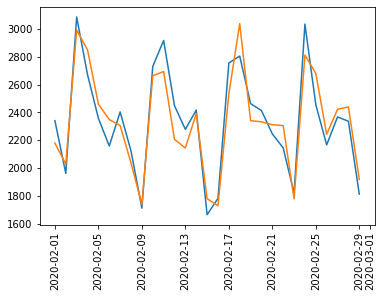

In [54]:
# plot a timeseries of daily visitors that were assigned to an experiment
# plot a line for each exp_id

# try looking at the pivot_table alone again
# pd.pivot_table(data=df, index='date_id',values='anonymous_id', columns='exp_id', aggfunc='count')

plt.plot(pd.pivot_table(data=df, index='date_id',values='anonymous_id', columns='exp_id', aggfunc='count'))
plt.xticks(rotation=90)
plt.show()

In [55]:
# does the time range match the experiment requirements?
# Do the lines indicate an equal assignment over time?

# add condition to dataframe to include time after Feb 1st (what Daniel did earlier! to account for people who may have visited the website, but were not assigned to the experiment, because there was no experiment running yet!)

## Describing the data

Compute the differences among the groups, before running a statistical test

In [56]:
# compute the number of conversion for each experiment group

pd.crosstab(df['exp_id'], df['subscriber']==True)

subscriber,False,True
exp_id,,
101.0,67394,493
102.0,67180,535


In [59]:
# compute the conversion rate for each experiment group

df_cr = pd.crosstab(df['exp_id'], df['subscriber']==True)
df_cr['conversion_rate'] = df_cr[True]/(df_cr[True]+df_cr[False])
df_cr

subscriber,False,True,conversion_rate
exp_id,,,
101.0,67394,493,0.007262
102.0,67180,535,0.007901


In [60]:
# interpret the results. From just looking at the numbers, which group performed better 
# with respect to conversions or conversion rates?

'''It appears that group 102 (variation) had a slightly higher conversion rate, 0.72% versus 0.79%. The Question is whether this difference is significant?''' 

'It appears that group 102 (variation) had a slightly higher conversion rate, 0.72% versus 0.79%. The Question is whether this difference is significant?'

You should see that there is a difference in the conversion rate across the different experiment groups.

Are there any differences among the subscibers for each group with respect to the client application they signed up through?

In [61]:
# Compute relative frequency for each client_app through which they subscribed in each experiment group
pd.crosstab(df['exp_id'], df['client_app'])

client_app,android,ios,web
exp_id,,,
101.0,105,135,253
102.0,107,161,267


In [62]:
# interpret and discuss the results

'''It appears that the web client drives more conversions, but the way the experiment is set up doesn't really let us answer this question fully. Doesnt make much sense.'''

"It appears that the web client drives more conversions, but the way the experiment is set up doesn't really let us answer this question fully. Doesnt make much sense."

## Test whether the difference in conversion rate is significant

It is time for the statistical test!

In [70]:
# compute the two arrays/series to be passed to the t-test
from scipy.stats import ttest_ind

a = df[df['exp_id']== 101]['subscriber']
b = df[df['exp_id']== 102]['subscriber']

# ttest_ind(a, b, equal_var=False)

Ttest_indResult(statistic=-1.3556897749411265, pvalue=0.17520015633882965)

In [18]:
# run the test and compute the p-value, without the equal variance assumption
ttest_ind(a, b, equal_var=False)

In [71]:
# Write up your conclusion and discuss

'''It appears that we FAIL to reject the null hypothesis (that there is no difference in performance, or that group A=B). There appears to be no significant difference in conversion rate.'''

'It appears that we FAIL to reject the null hypothesis (that there is no difference in performance, or that group A=B). There appears to be no significant difference in conversion rate.'

The experiment unfortunately did not result in a significant difference among the two groups. That is, you cannot conclude that the upsells were in fact improving the conversion rates. You still doubt whether you've done everything in the right way. 

During a coffee break, you overheard some colleague talking about how they are contemplating about getting newspaper subscription. They said they have been going to the newspaper website a few times already but they're not sure if they're willing to pay the price. You start thinking that you were maybe a little to rushed with starting the analysis on the first day after the experiment ended. It might take some time for people to subscribe after the first pageview...

In [76]:
# check the latest date a subscription was registered
df['date_id'].max()

Timestamp('2020-02-29 00:00:00')

In [81]:
# Using the Five-number summary, check how long it takes for users to subscribe after their first visit
df['time_to_subscribe'] = df['created_at'].dt.date - df['date_id'].dt.date # this dt.date is to account for the date_id haveing just date and the created_at having also a timestamp!!


df['time_to_subscribe'].describe()


count                      1028
mean     4 days 11:31:59.066147
std      4 days 18:35:45.632005
min             0 days 00:00:00
25%             1 days 00:00:00
50%             3 days 00:00:00
75%             7 days 00:00:00
max            28 days 00:00:00
Name: time_to_subscribe, dtype: object

In [22]:
# What is flawed when computing the five-number summary using this sample?

# NO IDEA: the 5-number summary is the mean, std, min, 25/50/75, max!!!

# it appears that maybe it doesn't consider the inner-quartile range? Or at least thats how the descriptive statistics appear to be "caluculated", or not.

## Considering time it takes to subscribe

The team decides to wait for the analysis until the end of the month to allow users to subscribe. On April 1st, the Product Manager approaches you with even more excitement and pushes you to redo the analysis.

The data for the additional subscribers that signed up between the day of your first analysis and today can be found in `data/2020-04-01/`.

**Important:** The new data does not include any of the data that were included in the previous datasets.

In [83]:
# load the newest data for subscriptions and their corresponding mapping in the users datasetsubscriptions = pd.read_csv('./data/2020-03-01/subscriptions_mar01.csv')
new_subscriptions = pd.read_csv('./data/2020-04-01/subscriptions_apr01.csv')
new_users = pd.read_csv('./data/2020-04-01/users_apr01.csv')

In [85]:
# combine the newest data with the existing datasets
new_exp_pv_with_user_id = pd.merge(exp_pv, new_users, on='anonymous_id', how='left')
new_exp_pv_with_user_id['is_there_user']= np.where(exp_pv_with_user_id['user_id'].isna(),0,1)
new_exp_pv_with_user_id.head()

,date_id,anonymous_id,exp_id,in_experiment,user_id,is_there_user
0,2020-02-01,c8bc65ae-e5bb-47b0-b2ba-a3e32f086c39,101.0,1,NaN,0
1,2020-02-01,5808da06-67c6-467f-bedd-aa872839ccde,101.0,1,NaN,0
2,2020-02-01,3265ddda-fefc-471f-b956-fa88b1d85e08,101.0,1,NaN,0
3,2020-02-01,0b633f23-c070-4289-b323-058c0a4105fb,101.0,1,NaN,0
4,2020-02-01,72c9c459-ae27-407a-a257-901678774df2,101.0,1,NaN,0


In [86]:
new_df = pd.merge(new_exp_pv_with_user_id, new_subscriptions, on='user_id', how='left')
new_df['subscriber'] = np.where(new_df['created_at'].isna(),0,1)
new_df.head()

,date_id,anonymous_id,exp_id,in_experiment,user_id,is_there_user,created_at,client_app,subscriber
0,2020-02-01,c8bc65ae-e5bb-47b0-b2ba-a3e32f086c39,101.0,1,NaN,0,NaN,NaN,0
1,2020-02-01,5808da06-67c6-467f-bedd-aa872839ccde,101.0,1,NaN,0,NaN,NaN,0
2,2020-02-01,3265ddda-fefc-471f-b956-fa88b1d85e08,101.0,1,NaN,0,NaN,NaN,0
3,2020-02-01,0b633f23-c070-4289-b323-058c0a4105fb,101.0,1,NaN,0,NaN,NaN,0
4,2020-02-01,72c9c459-ae27-407a-a257-901678774df2,101.0,1,NaN,0,NaN,NaN,0


In [25]:
# From here on, you're on your own. Redo the analysis from above with the new dataset.
# Make sure to run a few inspections to make sure your data is how you expect it to be
# After analyzing, provide a summary and a discussion including your communication to the Product Team

In [90]:
# we need to account for the NEW SUBSCRIBERS: concatenate the users and subscribers!

In [91]:
# Concatenate the 04_users to 03_users and 04_subscribers to 03_subscribers into ONE dataframe